<a href="https://colab.research.google.com/github/Wh1t3-H4wk/UtalcaMLCourse/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
import pandas as pd
import numpy as np
import requests
import csv

**Obtención de los datos**

Los datos son descargados realizando un GET request con la librería requests.

Dado que el CSV usa ; en vez de , con csv.reader se construye el documento para crear el DataFrame. 

In [2]:
data_url = "https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
data = requests.get(data_url)
lines = data.text.splitlines()
reader = csv.reader(lines, delimiter=';')
df = pd.DataFrame(reader, index=None)

Los datos incluyen celdas vacías (con whitespaces). Con df.replace se reemplazan las celdas por NaN

In [3]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       82416 non-null  object 
 1   1       82416 non-null  object 
 2   2       57744 non-null  object 
 3   3       16485 non-null  object 
 4   4       2744 non-null   object 
 5   5       0 non-null      float64
dtypes: float64(1), object(5)
memory usage: 3.8+ MB


**Manejo de datos faltantes**

df.info() muestra que hay columnas con datos faltantes.

La 5ta columna no tiene datos, por lo que debe ser eliminada.

In [5]:
#Se elimina la quinta columna dado que no tiene datos
df = df[[0,1,2,3,4]].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       82416 non-null  object
 1   1       82416 non-null  object
 2   2       57744 non-null  object
 3   3       16485 non-null  object
 4   4       2744 non-null   object
dtypes: object(5)
memory usage: 3.1+ MB


Al almacenar los datos en el DataFrame el header fue reconocido como fila por tanto hay que eliminar la primera fila para no causar problemas con los parseos

In [6]:
df = df.iloc[1: , :]
df

,0,1,2,3,4
1,120707,0100,NaN,NaN,NaN
2,120707,0200,NaN,NaN,NaN
3,120707,0300,NaN,NaN,NaN
4,120707,0400,NaN,NaN,NaN
5,120707,0500,NaN,NaN,NaN
...,...,...,...,...,...
82411,211130,1900,NaN,3,NaN
82412,211130,2000,NaN,7,NaN
82413,211130,2100,NaN,7,NaN
82414,211130,2200,NaN,11,NaN


Los datos utilizan la notación "," para puntos flotantes. Pero to_numeric pide la notación "." para realizar el casteo de string a punto flotante.

Con str.replace pasamos de "," a "." y transformamos los string a puntos flotantes.

In [7]:
df[2]=df[2].str.replace(',','.')
df[3]=df[3].str.replace(',','.')
df[4]=df[4].str.replace(',','.')

df[2] = pd.to_numeric(df[2])
df[3] = pd.to_numeric(df[3])
df[4] = pd.to_numeric(df[4])

df.replace(np.nan, 0, regex=True, inplace=True)

**Imputación de datos**

Los registros de contaminación se separan en tres tipos, validados, preliminares y no validados. 

Con el propósito de considerar el peor caso podemos tomar todos los registros y actuar sobre ellos como si fuesen todos validados. 

En el peor de los casos los registros no validados y preliminares no pasen a validados pero eso sería favorable para nuestra predicción pues significaría una disminución en la contaminación predicha y no un aumento por omisión.

***Etiquetado de columnas***

*Las columnas han sido etiquetadas acorde a lo declarado en la documentación de Prophet https://facebook.github.io/prophet/ para que funcione correctamente el predictor.* 

In [8]:
trimmed_df = pd.DataFrame()
trimmed_df[0] = df[0] + df[1]
trimmed_df[1] = df[2] + df[3] + df[4]
trimmed_df.columns = ['ds','y']

In [9]:
trimmed_df.replace(0, np.nan, regex=True, inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82415 entries, 1 to 82415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      82415 non-null  object 
 1   y       76965 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


Dado que existen días en los que no hubo registros estos han sido excluidos del DataFrame para no generar sesgos en el predictor.

In [10]:
trimmed_df.dropna(inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76965 entries, 16 to 82415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      76965 non-null  object 
 1   y       76965 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


**Formateo de las fechas**

Los strings que contienen fechas son casteados a la clase DateTime utilizando la expresión regular "%y%m%d%H%M" y el método de Pandas to_datetime.

In [11]:
trimmed_df["ds"] = pd.to_datetime(trimmed_df["ds"], format='%y%m%d%H%M', errors='ignore')
trimmed_df

,ds,y
16,2012-07-07 16:00:00,33.7100
17,2012-07-07 17:00:00,53.9500
18,2012-07-07 18:00:00,96.3999
19,2012-07-07 19:00:00,67.4298
20,2012-07-07 20:00:00,163.2000
...,...,...
82411,2021-11-30 19:00:00,3.0000
82412,2021-11-30 20:00:00,7.0000
82413,2021-11-30 21:00:00,7.0000
82414,2021-11-30 22:00:00,11.0000


**Serie de tiempo**

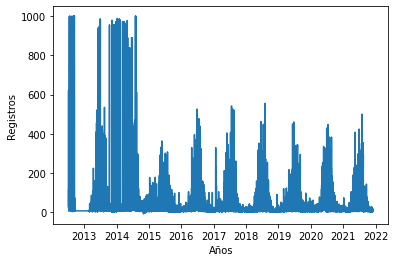

In [23]:
# plotting the line 2 points
plt.plot(trimmed_df["ds"], trimmed_df["y"])
 
# naming the x axis
plt.xlabel('Años')
# naming the y axis
plt.ylabel('Registros')

# function to show the plot
plt.show()

**Creación de los conjuntos Train y Test**

Dado que utilizamos Prophet para predecir registros al futuro separamos el conjunto original usando el método train_test_split de SkLearn.

Al separar es importante considerar un test size de 0.5 sin shuffle activo para contar con los datos ordenados cronológicamente.

Activar estos parámetros nos permiten utilizar el conjunto test para evaluar los registros resultantes del Prophet.

In [13]:
trimmed_df = trimmed_df.sort_values("ds")
train, test = train_test_split(trimmed_df, test_size=0.5, shuffle=False)

In [14]:
m = Prophet()
m.fit(train)

In [15]:
future = m.make_future_dataframe(periods=1095)
forecast = m.predict(future)

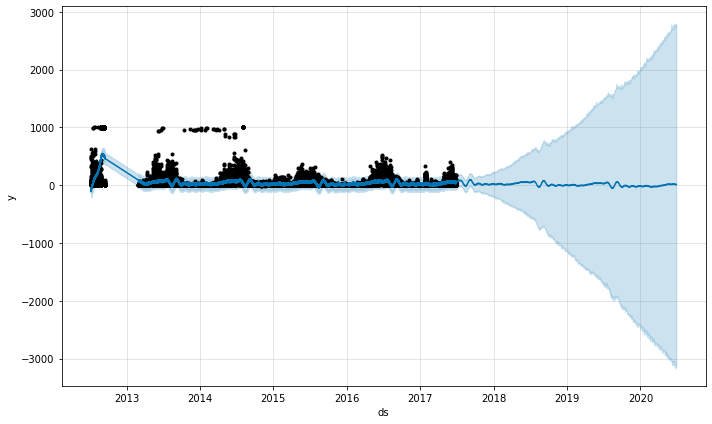

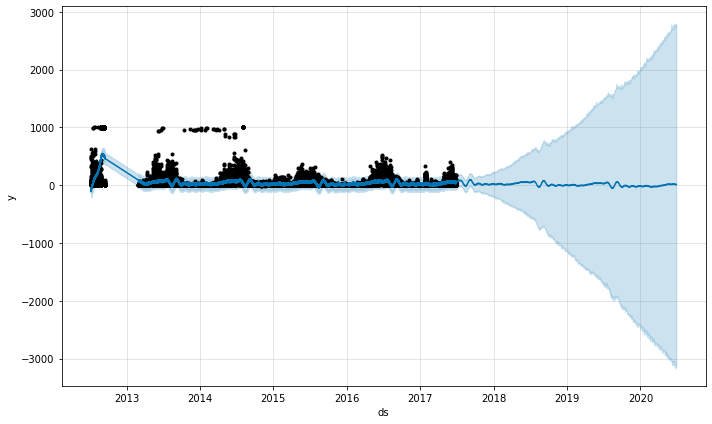

In [16]:
m.plot(forecast)

**Análisis de los resultados**

Al evaluar los resultados obtenidos mediante el error absoluto medio llegamos a un valor no tan favorable.

In [18]:
y_true = test['y'].values
y_pred = forecast['yhat'][-38483:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 39.118


Gráficamente el resultado no mejora, sin embargo demuestra un patrón interesante que en algunos puntos se asemeja a los valores apartados para testing.

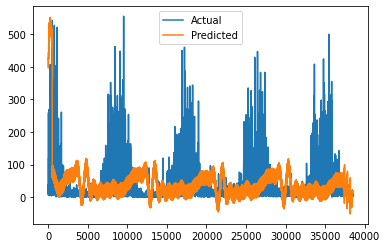

In [19]:
# plot predicted vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()